# pytorch monitor walkthrough

This notebook serves as an example and test of `pytorch-monitor`.

Pytorch is great. Dynamic computation and module composition make rapid prototyping of new deep learning architectures relatively simple. But as many machine learning engineers know, implementation time amounts to a small fraction of development relative to debugging and train/test evaluation.

For new architectures, we often want to monitor various metrics during training and testing:
* **Model parameter values:** Very large or skewed weight and bias distributions often are a sign of overfitting and small values can be due to underfitting or overregularization.
* **Parameter gradient values:** Viewing gradient distributions for model parameters can shed light on vanishing and exploding gradients.  
* **Model parameter update dynamics:** Understanding how model parameters change as a result of an optimization step can shed light on optimization issues. Consistently small parameter changes can indicate optimization is suffering from poor conditioning and large update values (especially late in training) often coincide with model performance divergences.
* **Intermediate computation activations and gradients:** For deeper or more complicated architectures, it's often useful to monitor intermediate model activation (forward) and jacobian (backward) distributions. This can be crucial in identifying problematic computation nodes and exploding/vanishing gradients.
* **Visualization of computation graph:** Visually inspecting the computation graph can be extremely useful in veryifying that your implementation plays out the same way as you drew it on the whiteboard.

To monitor these metrics we need:
1. Code that indicates the parameters, computations, and gradients to monitor within the model
2. Code that writes summaries of these marked computation nodes efficiently to logfiles
3. Code that provides an interface for inspecting the logs

Tensorboard==1.6 and tensorboardX are great tools for (2) and (3), but the use of tensorboardX for writing summaries of all useful computations (as in (1)) can still be timeconsuming.

This is where pytorch-monitor comes in. It's a simple library which aims to do two things:
1. Initialize and organize experiment logs easily while encouraging reproducability
2. Introspect initialized pytorch `Module`s and endow them with the necessary info to monitor themselves.

Our goal is for this process to be fast with sensible defaults, but flexible enough to allow for changes that meet user needs. With pytorch-monitor you can be off the ground monitoring your network behavior in as little as 2 lines of code.

In [1]:
from pytorch_monitor import init_experiment, monitor_module

## Example 1: The Basics



We start by initializing the experiment. 

In [2]:
config = {'title':'Test Monitor',
          'log_dir':'test'}
writer, config = init_experiment(config)
config

{'title': 'Test Monitor',
 'log_dir': 'test',
 'run_name': 'Apr-30-18@23:13:50-toms-mbp-2.lan',
 'run_dir': 'test/Apr-30-18@23:13:50-toms-mbp-2.lan',
 'tag': 'Experiment Config: Test Monitor :: Apr-30-18@23:13:50\n'}

A lot just happened:

We've taken the experiment config dictionary and does the following:
1. Creates a `run_name`
2. Creates a directory `run_name` in the path `log_dir`
3. If you use git to track your code, automatically commit the curent git repository. A reproducible snapshot of the code used to run the experiment. 
4. Initializes a tensorboardX `SummaryWriter`
5. Writes a tensorboard text log that logs all initial experiment metadata and configuration, such as start time, host name, random seed, and hyperparameters. This can be very useful reference when comparing multiple runs from tensorboard and drawing conclusions.
6. If a `random_seed` is provided, it sets the seed for python, numpy, and torch all at once.
7. Dumps the config dictionary to file in the `log_dir` as `config.json`
8. Returns the writer and config dictionary, augmented with the `run_name`, `run_dir`, and `tag`.

I've found this initialization strategy to be comprehensive enough for my needs, but I'm sure it could be better. Submit an issue or pull request if you have suggestions!

Next we'll create a simple nonlinear 1-d regression in pytorch. It will take a scalar input x, run it through a nonlinear layer, and produce a scalar output.

We'll train it to predict the sine function. $y = sin(x)$

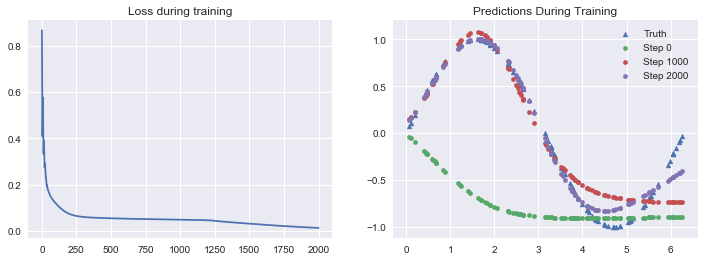

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
sb.set()

# Declare the model
class Model(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.encode = nn.Linear(1, hidden_dim)
        self.decode = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        h = F.tanh(self.encode(x))
        self.monitor('h', h, track_data=True, track_grad=True)
        return self.decode(h)

# Get inputs and gold outputs
x = 2 * 3.1415 * torch.rand(100,1)
y = x.sin()

# Setup the model and optimizer to have 10 hidden units
model = Model(10)
monitor_module(model, writer, track_update_ratio=True)
optimizer  = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

_, (ax0, ax1) = plt.subplots(1,2, figsize=(12,4))
# Train the model for 4001 steps, recording its predictions every 2000
losses = []
ax1.scatter(x.numpy(), y.numpy(), label='Truth', s=25, marker='^')
epochs = 2001
for i in range(epochs):
    print(i,':', end='')
    if i % 1000 == 0:
        model.monitoring(True)
    else:
        model.monitoring(False)
    yhat = model(x)
    loss = ((yhat - y)**2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    writer.add_scalar('train loss', loss.item(), i)
    
    if i % (epochs//2) == 0:
        ax1.scatter(x.numpy(), yhat.detach().numpy(), label='Step {}'.format(i), s=20)

ax0.plot(list(range(len(losses))), losses)
ax0.set_title('Loss during training')
ax1.set_title('Predictions During Training')
_ = ax1.legend()